In [1]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import roc_auc_score, make_scorer
from category_encoders import TargetEncoder
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import os
from datetime import datetime
from skopt import BayesSearchCV
import sys
from contextlib import contextmanager

# Redirect stdout and stderr to logger
@contextmanager
def stdout_redirector(stream):
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    sys.stdout = stream
    sys.stderr = stream
    try:
        yield
    finally:
        sys.stdout = old_stdout
        sys.stderr = old_stderr

class StreamToLogger:
    def __init__(self, logger, log_level=logging.INFO):
        self.logger = logger
        self.log_level = log_level
        self.linebuf = ''

    def write(self, buf):
        for line in buf.rstrip().splitlines():
            self.logger.log(self.log_level, line.rstrip())

    def flush(self):
        pass

# Get the current timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Define the log file name with the timestamp
log_file_name = f'training_{timestamp}.log'

# Check if a similar log file exists and remove it if necessary
if os.path.exists('training.log'):
    os.remove('training.log')

# Configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create handlers
console_handler = logging.StreamHandler()
file_handler = logging.FileHandler(log_file_name)

# Set log level for handlers
console_handler.setLevel(logging.INFO)
file_handler.setLevel(logging.INFO)

# Create formatters and add them to the handlers
console_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
console_handler.setFormatter(console_format)
file_handler.setFormatter(file_format)

# Add handlers to the logger
logger.addHandler(console_handler)
logger.addHandler(file_handler)

# Redirect stdout and stderr to the logger
sys.stdout = StreamToLogger(logger, logging.INFO)
sys.stderr = StreamToLogger(logger, logging.ERROR)

# Example logging usage
logger.info("Setup and Imports complete.")


2024-07-13 21:25:09,935 - __main__ - INFO - Setup and Imports complete.


In [2]:
# Cell 2: Load and Prepare Data
logger.info("Loading and preparing data...")

def reduce_memory_usage(df):
    """Iterate through all the columns of a dataframe and modify the data type to reduce memory usage."""
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {(100 * (start_mem - end_mem) / start_mem):.2f}%')
    
    return df

# Load datasets and reduce memory usage
train_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\preprocessed_train.csv")
test_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\preprocessed_test.csv")

train_df = reduce_memory_usage(train_df)
test_df = reduce_memory_usage(test_df)

# Drop ID column from training and test data
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

logger.info(f"Train dataset shape: {train_df.shape}")
logger.info(f"Test dataset shape: {test_df.shape}")

# Split the data into training and validation sets before preprocessing
X = train_df.drop(columns=['Response'])
y = train_df['Response']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

logger.info(f"Training set shape: {X_train.shape}")
logger.info(f"Validation set shape: {X_val.shape}")


2024-07-13 21:25:09,944 - __main__ - INFO - Loading and preparing data...
2024-07-13 21:25:24,902 - __main__ - INFO - Memory usage after optimization is: 218.68 MB
2024-07-13 21:25:24,903 - __main__ - INFO - Decreased by 79.17%
2024-07-13 21:25:25,255 - __main__ - INFO - Memory usage after optimization is: 138.98 MB
2024-07-13 21:25:25,256 - __main__ - INFO - Decreased by 78.41%
2024-07-13 21:25:25,746 - __main__ - INFO - Train dataset shape: (11465233, 11)
2024-07-13 21:25:25,747 - __main__ - INFO - Test dataset shape: (7669866, 10)
2024-07-13 21:25:30,277 - __main__ - INFO - Training set shape: (9172186, 10)
2024-07-13 21:25:30,278 - __main__ - INFO - Validation set shape: (2293047, 10)
2024-07-13 21:25:30,286 - __main__ - INFO - Defining custom transformers...
2024-07-13 21:25:30,288 - __main__ - INFO - Custom transformers defined.
2024-07-13 21:25:30,297 - __main__ - INFO - Defining preprocessing pipeline...
2024-07-13 21:25:32,652 - __main__ - ERROR - c:\Users\paulo\anaconda3\envs

In [3]:
# Cell 3: Define Custom Transformers
logger.info("Defining custom transformers...")

class InteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Age_Annual_Premium'] = X['Age'] * X['Annual_Premium']
        X['Age_Vintage'] = X['Age'] * X['Vintage']
        X['Annual_Premium_Vintage'] = X['Annual_Premium'] * X['Vintage']
        X['Age_Region_Code'] = X['Age'] * X['Region_Code']
        X['Vintage_Region_Code'] = X['Vintage'] * X['Region_Code']
        X['Annual_Premium_Region_Code'] = X['Annual_Premium'] * X['Region_Code']
        self.feature_names = X.columns.tolist()
        return X

class PolynomialFeatureGeneration(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        self.feature_names = None
    
    def fit(self, X, y=None):
        self.poly.fit(X[['Age', 'Annual_Premium', 'Vintage']])
        return self
    
    def transform(self, X):
        poly_features = self.poly.transform(X[['Age', 'Annual_Premium', 'Vintage']])
        poly_feature_names = self.poly.get_feature_names_out(['Age', 'Annual_Premium', 'Vintage'])
        poly_df = pd.DataFrame(poly_features, columns=[f'poly_{name.replace(" ", "_")}' for name in poly_feature_names], index=X.index)
        X = pd.concat([X, poly_df], axis=1)
        self.feature_names = X.columns.tolist()
        return X

logger.info("Custom transformers defined.")


In [4]:
# Cell 4: Define Preprocessing Pipeline
logger.info("Defining preprocessing pipeline...")

pipeline = Pipeline([
    ('interactions', InteractionFeatures()),
    ('poly_features', PolynomialFeatureGeneration()),
    ('scaling', StandardScaler(with_mean=False))  # Preserve feature names
])

# Apply the preprocessing pipeline
X_train_preprocessed = pipeline.fit_transform(X_train, y_train)
X_val_preprocessed = pipeline.transform(X_val)

# Ensure feature names are preserved
feature_names = pipeline.named_steps['poly_features'].feature_names
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_val_preprocessed = pd.DataFrame(X_val_preprocessed, columns=feature_names)

logger.info(f"Training set after preprocessing: {X_train_preprocessed.shape}")
logger.info(f"Validation set after preprocessing: {X_val_preprocessed.shape}")



In [5]:
# Cell 5: Save Transformed Data
logger.info("Saving transformed data...")

def save_csv(dataframe, filename):
    if os.path.exists(filename):
        os.remove(filename)
    dataframe.to_csv(filename, index=False)

save_csv(pd.DataFrame(X_train_preprocessed), 'X_train_transformed_reduced.csv')
save_csv(pd.DataFrame(X_val_preprocessed), 'X_val_transformed_reduced.csv')
save_csv(pd.DataFrame(y_train).reset_index(drop=True), 'y_train_transformed_reduced.csv')
save_csv(pd.DataFrame(y_val).reset_index(drop=True), 'y_val_transformed_reduced.csv')

logger.info("Transformed datasets saved to CSV files with reduced memory usage")

# # If needed, load the transformed datasets from CSV
# X_train_preprocessed = pd.read_csv('X_train_transformed_reduced.csv')
# X_val_preprocessed = pd.read_csv('X_val_transformed_reduced.csv')
# y_train = pd.read_csv('y_train_transformed_reduced.csv')
# y_val = pd.read_csv('y_val_transformed_reduced.csv')


In [6]:
# Cell 6: Run Bayesian Search for Hyperparameter Tuning
logger.info("Running Bayesian search for hyperparameter tuning...")

def run_bayesian_search(X_train, y_train):
    # Define the parameter grid
    param_dist = {
        'learning_rate': (0.03, 0.1),
        'num_leaves': (60, 120),
        'max_depth': (10, 15),
        'min_data_in_leaf': (10, 50),
        'bagging_fraction': (0.6, 0.8),
        'feature_fraction': (0.6, 0.8),
        'lambda_l1': (0.0, 1.0),
        'lambda_l2': (0.0, 1.0),
        'bagging_freq': (1, 7)
    }

    # Initialize the LightGBM classifier
    lgb_model = lgb.LGBMClassifier(objective='binary', metric='auc')

    # Define the scoring function
    scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

    # Initialize BayesSearchCV
    bayes_search = BayesSearchCV(
        estimator=lgb_model,
        search_spaces=param_dist,
        n_iter=1,  # Number of iterations for the search
        scoring=scorer,
        cv=3,  # 3-fold cross-validation
        random_state=42,
        verbose=2,
        n_jobs=-1
    )

    # Fit BayesSearchCV
    bayes_search.fit(X_train, y_train)

    return bayes_search.best_estimator_, bayes_search.best_params_, bayes_search.best_score_

# Run Bayesian Search
best_model, best_params, best_score = run_bayesian_search(X_train_preprocessed, y_train)

logger.info(f"Best AUC: {best_score}")
logger.info(f"Best parameters: {best_params}")

# Save the best trial parameters
pd.DataFrame([best_params]).to_csv('best_params_bayesiansearch.csv', index=False)

# Load the best parameters from the saved file (if needed)
best_params_loaded = pd.read_csv('best_params_bayesiansearch.csv').to_dict(orient='records')[0]

# Optionally, you can refit the model on the entire training set using the best parameters
best_model_retrained = lgb.LGBMClassifier(**best_params_loaded)
best_model_retrained.fit(X_train_preprocessed, y_train)

logger.info("Bayesian search complete.")


In [7]:
# Cell 7: Model Evaluation
logger.info("Evaluating model...")

def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Evaluate the best model on the training set
    train_preds = model.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, train_preds)

    # Evaluate the best model on the validation set
    val_preds = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds)

    logger.info(f"Training AUC with best parameters: {train_auc}")
    logger.info(f"Validation AUC with best parameters: {val_auc}")

    # Check for overfitting
    overfit_threshold = 0.05  # Adjust the threshold as needed
    overfit_metric = abs(train_auc - val_auc)
    if overfit_metric > overfit_threshold:
        logger.warning(f"Overfitting detected: Train AUC - {train_auc}, Val AUC - {val_auc}, Difference - {overfit_metric}")
    else:
        logger.info(f"No overfitting detected: Train AUC - {train_auc}, Val AUC - {val_auc}, Difference - {overfit_metric}")

    return train_auc, val_auc

# Evaluate the best model
train_auc, val_auc = evaluate_model(best_model_retrained, X_train_preprocessed, y_train, X_val_preprocessed, y_val)

logger.info("Model evaluation complete.")


In [8]:
# Cell 8: Train Final Model with Callbacks
logger.info("Training final model with callbacks...")

def train_final_model(params, X_train, y_train, X_val, y_val):
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, free_raw_data=False)

    # Define the early stopping callback
    early_stopping_callback = lgb.early_stopping(stopping_rounds=20, first_metric_only=True, verbose=True)

    # Train the LightGBM model with the best parameters
    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[train_data, val_data],
        callbacks=[early_stopping_callback],
    )

    return model

# Train the final model
final_model = train_final_model(best_params_loaded, X_train_preprocessed, y_train, X_val_preprocessed, y_val)


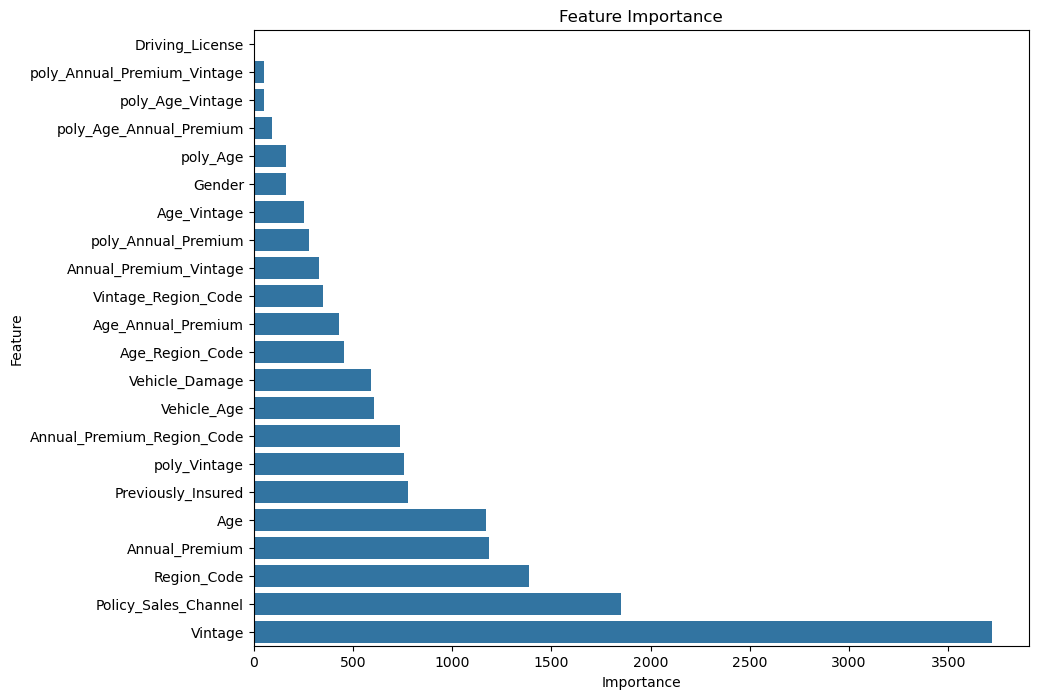

In [9]:
# Cell 9: Save Model and Metrics
logger.info("Saving model and metrics...")

def save_csv(dataframe, filename):
    if os.path.exists(filename):
        os.remove(filename)
    dataframe.to_csv(filename, index=False)

def save_model_and_metrics(model, X_train, y_train, X_val, y_val):
    # Predict on train and validation set
    y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)

    # Evaluation metrics
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    logger.info(f"Final Train AUC: {train_auc}")
    logger.info(f"Final Validation AUC: {val_auc}")

    # Feature Importance
    importance = model.feature_importance(importance_type='split')
    feature_names = X_train.columns

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Save feature importance to CSV
    save_csv(feature_importance_df, "feature_importance.csv")
    logger.info("Feature importance saved as feature_importance.csv")

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.savefig("feature_importance.png")
    logger.info("Feature importance plot saved as feature_importance.png")

    plt.show()

    # Save the model and metrics
    if os.path.exists("lightgbm_model_best.pkl"):
        os.remove("lightgbm_model_best.pkl")
    joblib.dump(model, "lightgbm_model_best.pkl")
    logger.info("Model saved as lightgbm_model_best.pkl")

    # Save the metrics to a CSV file
    metrics = {
        "train_auc": train_auc,
        "val_auc": val_auc
    }

    metrics_df = pd.DataFrame(metrics, index=[0])
    save_csv(metrics_df, "model_metrics.csv")
    logger.info("Model metrics saved as model_metrics.csv")

    # Final log message
    logger.info("Training and evaluation process completed successfully.")

# Save the model and metrics
save_model_and_metrics(final_model, X_train_preprocessed, y_train, X_val_preprocessed, y_val)



In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the original dataset
train_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\preprocessed_train.csv")

# 1. Distribution Analysis
features = ['Vintage', 'Policy_Sales_Channel', 'Region_Code', 'Annual_Premium', 'Age', 'Previously_Insured']

def plot_distribution(data, features, target, filename, figsize=(18, 18)):
    plt.figure(figsize=figsize)
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 2, i)
        sns.histplot(data[feature], kde=True)
        plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

plot_distribution(train_df, features, 'Response', 'distribution_plots.png')

# 2. Relationship Analysis
def plot_relationship(data, features, target, filename, figsize=(18, 18)):
    plt.figure(figsize=figsize)
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 2, i)
        sns.boxplot(x=target, y=feature, data=data)
        plt.title(f'Relationship between {feature} and {target}')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

plot_relationship(train_df, features, 'Response', 'relationship_plots.png')

# 3. Outlier Detection
def plot_outliers(data, features, filename, figsize=(18, 18)):
    plt.figure(figsize=figsize)
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 2, i)
        sns.boxplot(data[feature])
        plt.title(f'Outlier detection for {feature}')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

plot_outliers(train_df, features, 'outlier_detection_plots.png')

# 4. Data Leakage Investigation
def investigate_data_leakage(data, features, target, filename):
    correlations = {}
    for feature in features:
        correlation = data[feature].corr(data[target])
        correlations[feature] = correlation
        print(f'Correlation between {feature} and {target}: {correlation}')
    
    # Save correlations to a CSV file
    pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation']).to_csv(filename)

investigate_data_leakage(train_df, features, 'Response', 'data_leakage_correlations.csv')


Correlation between Vintage and Response: -0.015147543653213363
Correlation between Policy_Sales_Channel and Response: -0.15332952949041312
Correlation between Region_Code and Response: 0.01278183952433077
Correlation between Annual_Premium and Response: 0.032479161069385
Correlation between Age and Response: 0.12342063526589969
Correlation between Previously_Insured and Response: -0.34628976098809716
